# 算式识别毕业项目

## 1. 数据集分析与可视化

In [1]:
from dataset_keras import df_label,symbols

symbols_count = dict()
for symbol in symbols:
    symbols_count[symbol] = 0
    df_label[symbol] = 0
df_label.head()

,label,label_len,LEN,0,1,2,3,4,5,6,7,8,9,+,-,*,=,(,)
filename,,,,,,,,,,,,,,,,,,,
train/0.jpg,(0+0)+9=9,9,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
train/1.jpg,9*8+6=78,8,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
train/2.jpg,1+7+0=8,7,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
train/3.jpg,5+4+9=18,8,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
train/4.jpg,7-(1*7)=0,9,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [2]:
def label_count(label):
    tmp = [label.count(symbol) for symbol in symbols]
    return tmp

import pandas as pd
tmp = df_label.label.apply(label_count)
for idx, symbol in enumerate(symbols):
    _ = [a[idx] for a in tmp]
    df_label[symbol] = _
df_label.head()

,label,label_len,LEN,0,1,2,3,4,5,6,7,8,9,+,-,*,=,(,)
filename,,,,,,,,,,,,,,,,,,,
train/0.jpg,(0+0)+9=9,9,11,2,0,0,0,0,0,0,0,0,2,2,0,0,1,1,1
train/1.jpg,9*8+6=78,8,11,0,0,0,0,0,0,1,1,2,1,1,0,1,1,0,0
train/2.jpg,1+7+0=8,7,11,1,1,0,0,0,0,0,1,1,0,2,0,0,1,0,0
train/3.jpg,5+4+9=18,8,11,0,1,0,0,1,1,0,0,1,1,2,0,0,1,0,0
train/4.jpg,7-(1*7)=0,9,11,1,1,0,0,0,0,0,2,0,0,0,1,1,1,1,1


10    35177
9     27156
8     17759
7     12149
11     7759
Name: label_len, dtype: int64

<Container object of 5 artists>

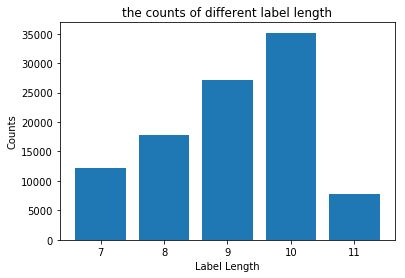

In [3]:
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

df_label.label_len.value_counts()
plt.bar(df_label.label_len.value_counts().index.tolist(), df_label.label_len.value_counts())
plt.xlabel('Label Length')
plt.ylabel('Counts')
plt.title('the counts of different label length')
# plt.savefig('report/images/label_length_counts.jpg')

<Container object of 16 artists>

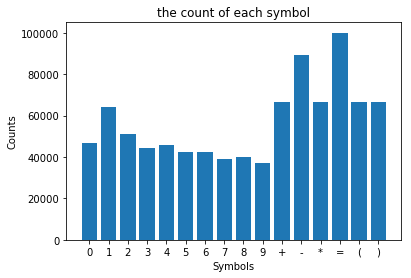

In [4]:
fig,ax = plt.subplots()

ax.bar(range(1,len(symbols)+1),df_label.loc[:,list(symbols)].sum(axis=0))
_ = ax.set_xticks(range(1,len(symbols)+1))
_ = ax.set_xticklabels(symbols)
_ = ax.set_xlabel('Symbols')
_ = ax.set_ylabel('Counts')
_ = ax.set_title('the count of each symbol')
# plt.savefig('report/images/each_symbol_counts.jpg')

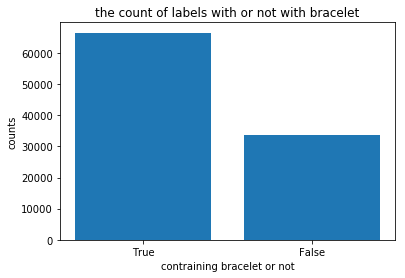

In [5]:
df_label['bracelet'] = ['(' in label for label in df_label.iloc[:,0]]
tmp = df_label['bracelet'].value_counts()
fig,ax = plt.subplots()
_ = ax.bar([0,1], tmp)
_ = ax.set_xticks([0,1])
_ = ax.set_xticklabels(['True', 'False'])
_ = ax.set_xlabel('contraining bracelet or not')
_ = ax.set_ylabel('counts')
_ = ax.set_title('the count of labels with or not with bracelet')
# plt.savefig('report/images/symbol_bracelet_counts.jpg')

## 2. 模型的构建
### 2.1. 随机验证码图片

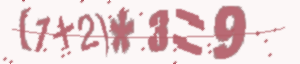

In [6]:
from captcha.image import ImageCaptcha
import os
import string

symbols = string.digits+"+-*=()"
width, height, n_len, n_class = 300, 64, 15, len(symbols) + 1
from IPython.display import display

generator = ImageCaptcha(width=width, height=height, font_sizes=range(43, 53), 
                         fonts=['fonts/%s'%x for x in os.listdir('fonts') if '.ttf' in x])
display(generator.generate_image('(1+2)*3=9'))

In [7]:
import random
def gen_captcha(cap_len, bracelet=True,equation=True):
    
    ops = ["+","-","*"]
    bracelet = random.choice([True,False])
    if bracelet:
        braces = [1,1]
        braces[0] = random.choice(range(cap_len-1))
        braces[1] = random.choice(range(braces[0]+1,cap_len))
    else:
        braces = [-1,-1]
    
    def get_factor(num):
        return [str(a) for a in range(1,num+1) if num%a==0]

    def last_index(string,obj,begin=0):
        index = string.find(obj,begin)
        if index == -1:
            return begin-1
        return last_index(string,obj,index+1)
    
    def get_num(tmp):
        if int(eval(tmp)) == 0:
                num = np.random.choice([str(a) for a in range(1,10)])
        else:
            num = np.random.choice(get_factor(int(eval(tmp))))
        return num

    
    char = []
    num = np.random.choice([str(a) for a in range(10)])
    if braces[0] == 0:
        char.append('(')
    char.append(num)
    
    for i in range(cap_len-1):
        if i==braces[1]:
            char.append(')')
        tmp = ''.join(char) 
#         print(tmp)
        op = np.random.choice(ops)
        char.append(op)

        if (op=='/'):
            if ('(' in tmp) and (')' not in tmp):
                tmp = tmp[tmp.find('(')+1:] 
            elif ')' in tmp[:-1]:
                tmp = tmp[tmp.find(')')+1:]
            elif ')' == tmp[-1]:
                tmp = tmp[tmp.find('(')+1:-1]
            idx = max(last_index(tmp,'+'),last_index(tmp,'-'))
#             print(tmp)
#             print(idx)
            if idx != -1:
                tmp = tmp[idx+1:]
                num = get_num(tmp)
            else:
                num = get_num(tmp)
        else:
            num = np.random.choice([str(a) for a in range(10)])
            
        if i+1==braces[0]:
            char.append('(')
        char.append(num)

    if braces[1]==cap_len-1:
        char.append(')')
    chars = ''.join(char)
    if chars[chars.find('(')-1] == '/':
        tmp = chars[chars.find('(')+1:chars.find(')')]
        chars1 = chars[:chars.find('(')+1]
        chars2 = chars[chars.find(')'):]
        cap_len = len(tmp)//2+1
        while int(eval(tmp))==0:
            tmp = gen_captcha(cap_len, bracelet=False, equation=False)
        chars = chars1+tmp+chars2
    if equation:
        return chars+'='+str(int(eval(chars)))
    return chars

gen_captcha(3)

'0*4*1=0'

## 2.2. 数据生成器

In [9]:
import os
import cv2
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 

import string
symbols = string.digits + '+-*=()'
nClass = len(symbols)

csv_path = 'Data/train.csv'
df_label = pd.read_csv(csv_path, index_col=0)
df_label['label_len'] = df_label['label'].apply(len)
MAX_LABEL_LEN = df_label.label_len.max()
df_label['LEN'] = MAX_LABEL_LEN

class dataset(object):
    
    def __init__(self, train=True, test=False, dir='Data/train_dir/train', size=(64,300), shuffle=False):
        self.train = train
        self.test = test
        self.shuffle = shuffle
        self.dir = dir
        self.target_size = size
        self.batch_index = 0
        self.files_origin = os.listdir(self.dir)
        self.seed = 112233
        self.files = self.gen_files()
        self.length = len(self.files)

    def gen_files(self, train=True):
        if self.test:
            return self.files_origin
        train_files, val_files = train_test_split(self.files_origin, test_size=0.3
                                                  ,random_state=self.seed)
        if self.train:
            return train_files
        return val_files
    
    def get_batch(self, batch_size=50, color_mode='grayscale'):
    
        while True:
            if (self.batch_index+1)*batch_size >= self.length: 
                files = self.files[self.batch_index*batch_size:]               
                self.batch_index = 0
                random.seed(self.seed)
                self.seed = random.randint(0,100)
                self.files = self.gen_files()
            else:
                files = self.files[self.batch_index*batch_size:(self.batch_index+1)*batch_size]
                self.batch_index += 1   
                
            batch_size = len(files)
            
            labels = -1* np.ones((batch_size, 11),dtype=np.int32)
            label_lengths = np.zeros(batch_size)
            imgs = np.zeros((batch_size, 64,300,1),dtype=np.uint8)
            
            for i,file in enumerate(files):
                label = df_label.loc['train/'+file, 'label']
                labels[i,:len(label)] = [symbols.find(c) for c in label]
                label_lengths[i] = len(label)
                img = cv2.imread(os.path.join(self.dir,file),cv2.IMREAD_GRAYSCALE)
                imgs[i] = img[:,:,np.newaxis]
            
            input_lengths = np.array([17]*batch_size)
            yield [imgs, labels, input_lengths, label_lengths], np.ones(batch_size)
            
    # 随机验证码数据生成器
    def gen_data(batch_size = 50):

        width, height = 300, 64
        imgs = np.zeros([batch_size, height, width, 1], dtype=np.uint8)
        labels = -1*np.ones([batch_size, 11], dtype=np.int32)
        label_lens = np.zeros(batch_size)
        while True:
            for i in range(batch_size):
                label = gen_captcha(3)
                img = np.array(generator.generate_image(label))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                imgs[i] = img[:,:,np.newaxis]
                labels[i,:len(label)] = [symbols.find(x) for x in label]
                label_lens[i] = len(label)
            yield [imgs, labels, np.ones(batch_size)*int(17), label_lens], np.ones(batch_size)


In [10]:
data = dataset()
valid_data = dataset(train=False)

## 3. 训练模型构建

In [11]:
from keras.layers import Input, Dense, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Reshape, Lambda
from keras.layers.recurrent import GRU
from keras.layers.merge import add, concatenate
from keras.activations import relu
from keras.models import Model

import tensorflow as tf

(img_h,img_w) = (64,300) 
input_shape = (img_h, img_w,1)
act = 'relu'
conv_filters = [16, 32, 64, 128, 128, 128, 256, 256, 1]
kernel_size = [3, 3, 3, 3, 3, 3, 2, 2]
pool_size = 2
batch_normal = [True]*8
max_pool_2d = [True, True, False, True, False, True, False, False]
max_pool_size = [2,2,0,2,0,2,0,2]
max_pool_stride = [2,2,0,2,0,(1,2),0,(1,2)]

time_dense_size = 32
rnn_size = 128

def convRelu(input_data, i, batch_normal=False, max_pool=False):
    
    input_data = Conv2D(conv_filters[i],kernel_size[i],
                  padding='same', activation=relu, 
                  kernel_initializer='he_normal', 
                  name='conv{}'.format(i+1))(input_data)
    if batch_normal:
        input_data = BatchNormalization(axis=-1)(input_data)
    if max_pool:
        input_data = MaxPooling2D(max_pool_size[i], max_pool_stride[i], 
                                  padding='same')(input_data)
    return input_data

input_data = Input(name='input_data', shape=input_shape, dtype='float32')

inner = input_data
for index,_ in enumerate(kernel_size):
    inner = convRelu(inner, index, batch_normal=batch_normal[index], 
                     max_pool=max_pool_2d[index])

print(np.shape(inner))    
conv_to_rnn_dims = (19, 8*256)
inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

inner = Dense(time_dense_size, activation=act, name='cnn_out')(inner)

gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal',
           name='gru1')(inner)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True,
             kernel_initializer='he_normal', name='gru1_b')(inner)

gru1_merged = add([gru_1, gru_1b])

gru_2 = GRU(rnn_size, return_sequences=True, 
           kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
             kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

inner = Dense(17, kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
y_pred = Activation('softmax', name='softmax')(inner)

base_model = Model(input=input_data, output=y_pred)
base_model.summary()

Using TensorFlow backend.


(?, 8, 19, 256)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         (None, 64, 300, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 300, 16)  160         input_data[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 300, 16)  64          conv1[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 150, 16)  0           batch_normalization_1[0][0]      
_____________________________________________________________________________________________

E:\learning\Anaconda3\envs\mnist\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`


In [12]:
import keras.backend as K
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def ctc_decode(y_pred):
#     y_pred = base_model.predict_on_batch(imgs)
#     shape = y_pred[:,2:,:].shape
#     out = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(50)*17)[0][0])[:, :11]
    out = K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(50)*17)[0][0]
    return out
#     y_pred, input_length =args
#     seq_len = tf.squeeze(input_length,axis=1)

#     return K.ctc_decode(y_pred=y_pred, input_length=seq_len, greedy=True, beam_width=100, top_paths=1)

In [13]:
from keras.optimizers import SGD
# y_pred = Input(name='y_pred', shape=[19,17], dtype='float32')
labels = Input(name='the_labels', shape=[11], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')\
            ([base_model.output, labels, input_length, label_length])           

sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)

out = Lambda(ctc_decode, output_shape=[None,], name='decoder')(y_pred)

decode = K.function([y_pred],[out])

### 3.1. 模型可视化

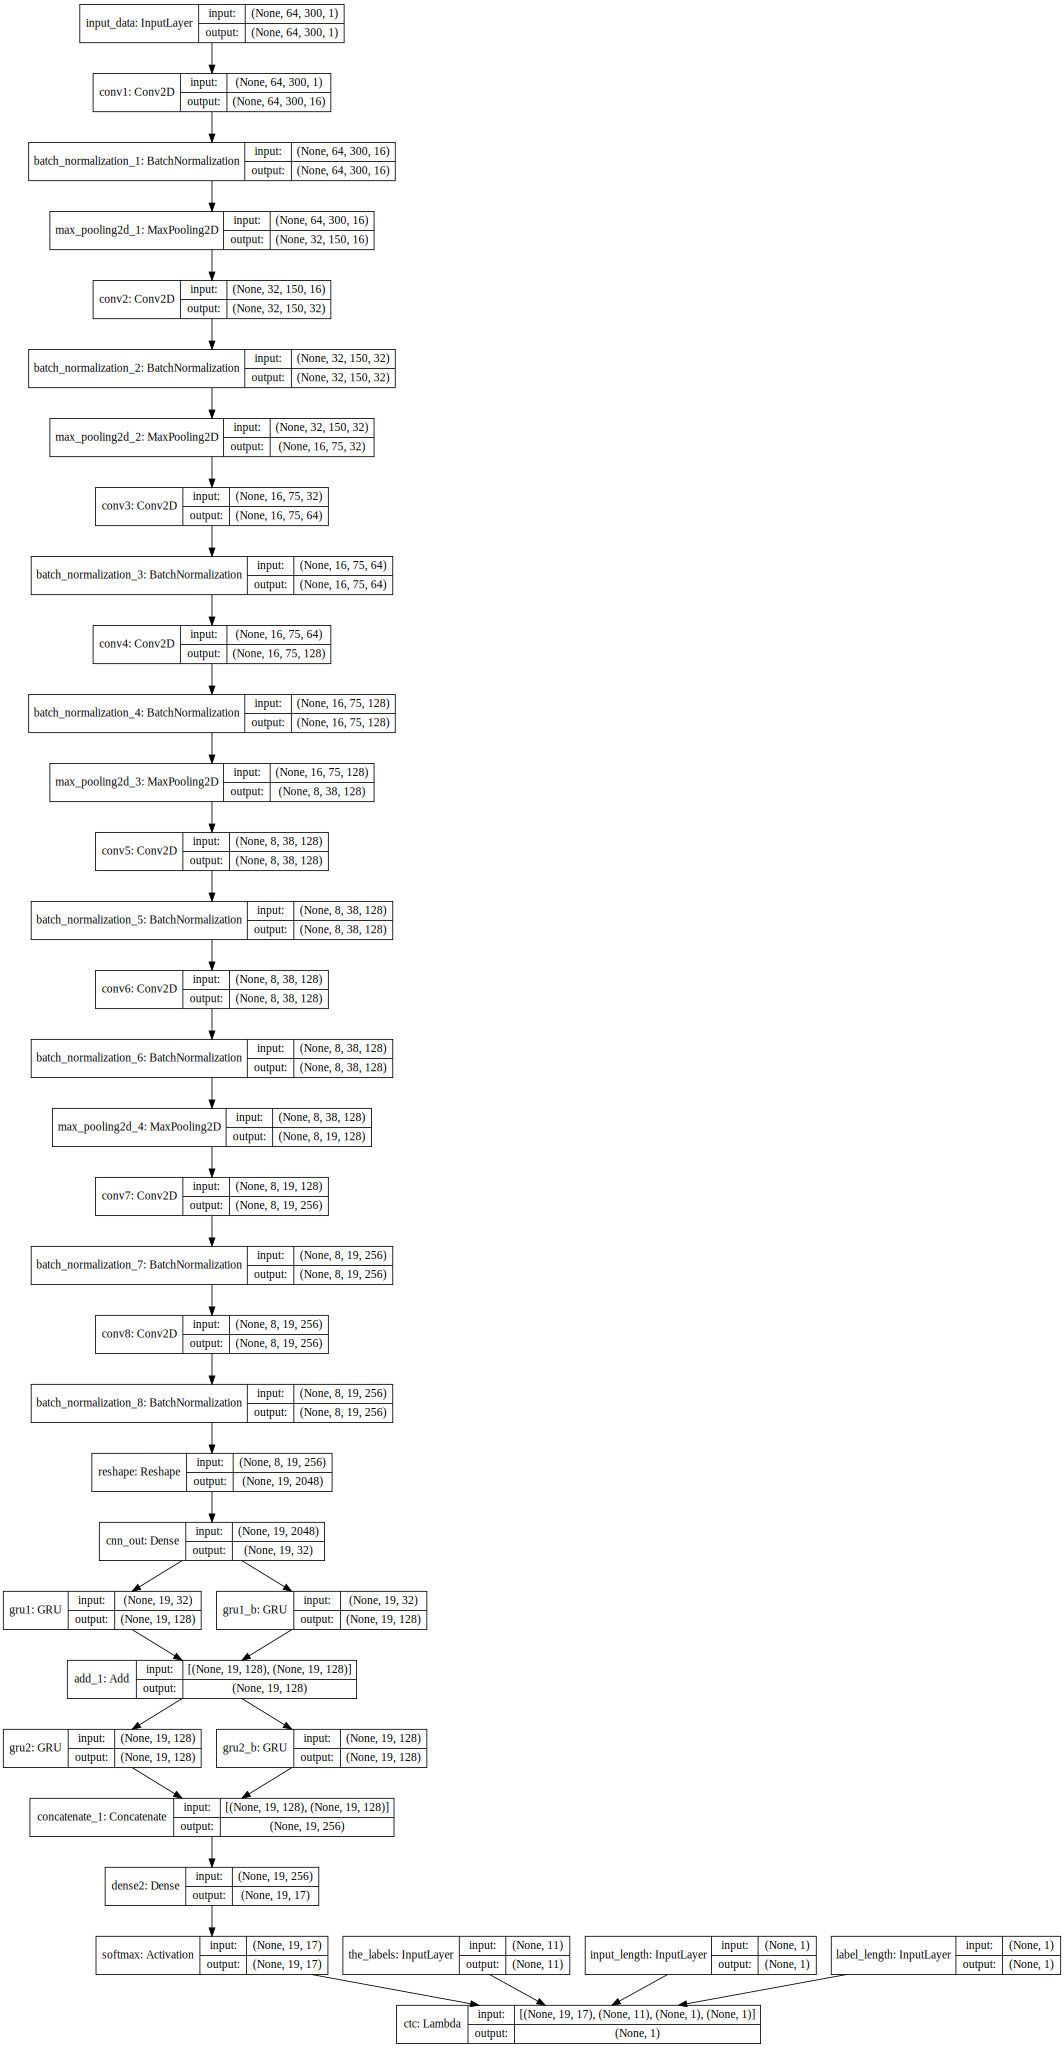

In [14]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
# plot_model(model, show_shapes=True, to_file='report/images/model3.png')

### 3.2. 模型训练结果
由于训练时间较长，利用脚本在服务器后台运行训练，训练输出在`train_captcha.log`和`train2.log`

In [36]:
# 利用随机生成数据训练
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
history = model.fit_generator(gen_data(), steps_per_epoch=100000/50, epochs=50,
                    validation_data=valid_data.get_batch(),
                              validation_steps=0.1*100000/50,
                   callbacks=[ReduceLROnPlateau('loss'),
                             ModelCheckpoint('../model/model_gtu_best.h5',save_best_only=True)])

Epoch 1/50
   2/2000 [..............................] - ETA: 10:33:53 - loss: 45.1431

KeyboardInterrupt: 

In [91]:
# 利用原数据集训练
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
history = model.fit_generator(data.get_batch(), steps_per_epoch=int(0.7*100000/50),
                              epochs=50,
                    validation_data=valid_data.get_batch(),
                              validation_steps=int(0.1*100000/50),
                   callbacks=[ReduceLROnPlateau('loss'),
                             ModelCheckpoint('../model/model_gtu_best.h5',save_best_only=True)])

Epoch 1/50
   8/1400 [..............................] - ETA: 5:11:09 - loss: 26.2022

KeyboardInterrupt: 

In [15]:
base_model.save('model/base_model.h5')

In [16]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

with open('train2.log','r') as f:
    lines = f.readlines()
    
loss = np.zeros(49)
val_loss = np.zeros(49)
val_lines = [line for line in lines if '1400/1400' in line]
print('the process of dataset data training:')
for idx,line in enumerate(val_lines):
    print('EPOCH: {}/50'.format(idx+1))
    print(line)
    tmp = line.split(' - ')
    loss[idx] = float(tmp[2].replace('loss: ',''))
    val_loss[idx] = float(tmp[3].replace('val_loss: ','').replace('\n',''))
    
with open('train_captcha.log','r') as f:
    lines = f.readlines()
val_lines = [line for line in lines if '2000/2000' in line]
    
loss_cap = np.zeros(4)
val_loss_cap = np.zeros(4)
print('the process of captcha data training:')
for idx,line in enumerate(val_lines):
    print('EPOCH: {}/50'.format(idx+1))
    print(line)
    tmp = line.split(' - ')
    loss_cap[idx] = float(tmp[2].replace('loss: ',''))
    val_loss_cap[idx] = float(tmp[3].replace('val_loss: ','').replace('\n',''))


the process of dataset data training:
EPOCH: 1/50
1400/1400 [==============================] - 1999s 1s/step - loss: 4.3129 - val_loss: 3.4882

EPOCH: 2/50
1400/1400 [==============================] - 2002s 1s/step - loss: 0.4890 - val_loss: 1.7151

EPOCH: 3/50
1400/1400 [==============================] - 1988s 1s/step - loss: 0.2697 - val_loss: 9.3167

EPOCH: 4/50
1400/1400 [==============================] - 1981s 1s/step - loss: 0.1929 - val_loss: 1.7617

EPOCH: 5/50
1400/1400 [==============================] - 2007s 1s/step - loss: 0.1353 - val_loss: 0.6645

EPOCH: 6/50
1400/1400 [==============================] - 1985s 1s/step - loss: 0.1025 - val_loss: 0.1661

EPOCH: 7/50
1400/1400 [==============================] - 1986s 1s/step - loss: 0.0832 - val_loss: 0.7490

EPOCH: 8/50
1400/1400 [==============================] - 2001s 1s/step - loss: 0.0688 - val_loss: 0.2161

EPOCH: 9/50
1400/1400 [==============================] - 1987s 1s/step - loss: 0.0562 - val_loss: 1.2888

EPOCH: 1

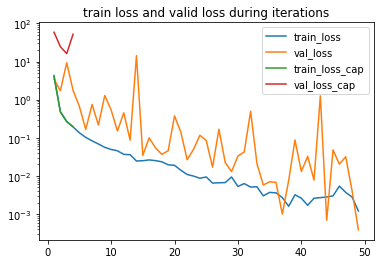

In [17]:
fig,ax = plt.subplots()
_ = ax.semilogy(range(1,50), loss, label='train_loss')
_ = ax.semilogy(range(1,50), val_loss, label='val_loss')
_ = ax.semilogy(range(1,5), loss_cap, label='train_loss_cap')
_ = ax.semilogy(range(1,5), val_loss_cap, label='val_loss_cap')
_ = ax.legend()
_ = ax.set_title('train loss and valid loss during iterations')
# plt.savefig('report/images/loss_condtion.png')

In [18]:
model.load_weights("model/model_gru_best.h5")
model.save('model/model.h5')
model_predict = K.function([model.layers[0].input],[model.layers[-5].output])
model_decode = K.function([model.layers[-5].output],[out])

### 3.3. 模型准确率

In [19]:
def toLabel(pred):
    output = []
    for char in pred:
        tmp = []
        for idx in char:
            if idx == -1:
                tmp.append(' ')
            else:
                tmp.append(symbols[idx])
        output.append(''.join(tmp))
    return output

def evaluate(out, labels, label_lens):
    accuracy = np.zeros(len(out))
    out_label = toLabel(out)
    labels_label = toLabel(labels)
    for idx in range(len(out)):
        accuracy[idx] = (out_label[idx][:int(label_lens[idx])] == labels_label[idx][:int(label_lens[idx])])
    return accuracy.sum()
    
valid_data = dataset(train=False)
[imgs, labels, input_lens, label_lens],_ = next(valid_data.get_batch(batch_size=50))
[y_pred_value] = model_predict([imgs])
[out_soft] = model_decode([y_pred_value])#[:,:11]
evaluate(out_soft, labels, label_lens)


50.0

在全数据集上的模型验证准确率为100%

In [23]:
accuracy = 0
test_data = dataset(test=True)
for batch in range(200):
    [imgs, labels, input_lens, label_lens],_ = next(test_data.get_batch())
    y_pred_value = base_model.predict_on_batch(imgs)
    [out_value] = model_decode([y_pred_value])
    accracy += evaluate(out_value, labels, label_lens)
    
print('the accuracy of the model is: {}\%'.format(accuracy/(200*50)*100))

the accuracy of the model is: 100.0\%


## 4. 模型预测结果

随机在8张图片上预测，均与其标签相符。

['11966.jpg',
 '34212.jpg',
 '64264.jpg',
 '57120.jpg',
 '9126.jpg',
 '92453.jpg',
 '26803.jpg',
 '46163.jpg']

['9-4*9=-27',
 '(0*2)+1=1',
 '9*7-7=56',
 '1+(1+6)=8',
 '5*8-5=35',
 '(0-1)+5=4',
 '(8*9)-9=63',
 '3+(0*9)=3']

[['9-4*9=-27'],
 ['(0*2)+1=1'],
 ['9*7-7=56'],
 ['1+(1+6)=8'],
 ['5*8-5=35'],
 ['(0-1)+5=4'],
 ['(8*9)-9=63'],
 ['3+(0*9)=3']]

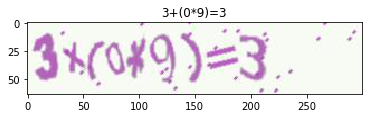

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

files = data.files_origin
np.random.shuffle(files)
files = ['11966.jpg', '34212.jpg', '64264.jpg', '57120.jpg', '9126.jpg', '92453.jpg',
         '26803.jpg', '46163.jpg']
labels = []
predicts = []

for i in range(8):
    img = plt.imread('Data/train_dir/train/'+files[i])
    _ = plt.imshow(img)
    label = df_label.loc['train/'+files[i], 'label']
    labels.append(label)
    _ = plt.title(label)
#     plt.savefig('report/images/test_{}.jpg'.format(i),bbox_inches='tight')
    img = cv2.imread('Data/train_dir/train/'+files[i],cv2.IMREAD_GRAYSCALE)
    img = np.array(img)
    img = img[np.newaxis,:,:,np.newaxis]
    y_pred = base_model.predict_on_batch(img)
    shape = y_pred[:,2:,:].shape
    out = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])[:, :11]
    predicts.append(toLabel(out))

files[:8]
labels
predicts

### 4.1. 模型在随机生成验证码上的预测效果

在随机生成图片上的预测结果及其不理想，根据模型训练的过程，猜想是由于随机生成的图片
与原数据集的图片本身的差异造成的，这些差异可能存在于字体，字号，随机图片的样式等等。

'(3*6)+5=23'

10

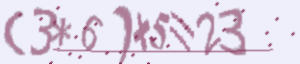

['(3*6)+5=23']

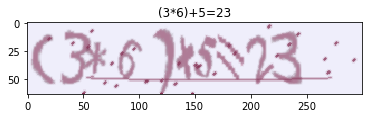

In [25]:
%matplotlib inline

label = gen_captcha(3)
while(len(label)>11):
    label = gen_captcha()

label
len(label)
img = generator.generate_image(label)
display(img)

img = np.array(img)
# cv2.imwrite('report/images/captcha4.png',img)
import matplotlib.pyplot as plt
plt.imshow(img)
plt.title(label)
# plt.savefig('report/images/captcha4.png',bbox_inches='tight')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img[np.newaxis,:,:,np.newaxis]
y_pred = base_model.predict(img)
shape = y_pred[:,2:,:].shape
out = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])[:, :11]
toLabel(out)